<a href="https://colab.research.google.com/github/KMB7/SenAnalyzer/blob/main/Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Stock Sentiment Analyzer using news headlines, PE ratio, DE ratio and Quarter on Quarter Growth %

Kripansh Mohit

21112065



In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import io
import time
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tqdm.notebook import tqdm
import yfinance as yf
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
pattern = re.compile(r'\.\.\.(.*?)\.\.\.(\w+ \d{1,2}, \d{4})')
def fetch_news_ft(page, arr,topic):
    url = f'https://www.ft.com/search?q={topic}&sort=date&isFirstView=true&page={page}'
    response = requests.get(url)

    try:
        soup = BeautifulSoup(response.content, 'html.parser')
        headlines = soup.find_all('div', class_='o-teaser__content')
        for headline in headlines:
            matches = re.findall(pattern, headline.text)
            obj = {}
            for match in matches:
                obj['Text'] = match[0].strip()
                obj['Date'] = match[1]
                arr.append(obj)
    except:
        print(f"Failed to retrieve the page. Status code: {response.status_code}")

In [3]:
arr = []
topic="automobiles"
for page in tqdm(range(1, 101)):
    fetch_news_ft(page, arr, topic)
autom = pd.DataFrame(arr)
autom.to_csv('autom.csv')
print(len(autom))
autom.head()

  0%|          | 0/100 [00:00<?, ?it/s]

166


,Text,Date
0,China is the third-largest market by value for...,"June 19, 2024"
1,The US reacted to this challenge with the Infl...,"June 19, 2024"
2,Auto industry-related employment — from fuel r...,"June 12, 2024"
3,"Under a $1bn-plus investment plan, BYD intends...","June 5, 2024"
4,"The Japanese, meanwhile, are keen to promote t...","June 3, 2024"


In [4]:
def fetch_news_nt(url,heads,dt):
  date_pattern = r'\b(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?) \d{1,2}, \d{4}\b'

  response = requests.get(url)
  soup = BeautifulSoup(response.content, 'html.parser')
  headlines = soup.find_all('h4', class_='css-nsjm9t')
  dates = soup.find_all('span', class_='css-coykat')
  for headline in headlines:
      heads.append(headline.text)
  for date in dates:
      match = re.search(date_pattern, date.text)
      extracted_date = match.group(0)
      dt.append(extracted_date)

In [5]:
url="https://www.nytimes.com/search?dropmab=false&endDate=2024-06-09&query=automobiles&sections=Technology%7Cnyt%3A%2F%2Fsection%2F4224240f-b1ab-50bd-881f-782d6a3bc527&sort=best&startDate=2023-06-09"
nytnews = []
dt = []
fetch_news_nt(url,nytnews,dt)

autom2 = pd.DataFrame({'Text': nytnews, 'Date': dt})
autom2.to_csv('autom2.csv')

print(len(autom2))
autom2.head()

10


,Text,Date
0,General Motors Quits Sharing Driving Behavior ...,"March 23, 2024"
1,G.M. to Cut Spending on Cruise Self-Driving Unit,"November 30, 2023"
2,Is Your Driving Being Secretly Scored?,"June 11, 2024"
3,Florida Man Sues G.M. and LexisNexis Over Sale...,"March 16, 2024"
4,Your Car Is Tracking You. Abusive Partners May...,"December 31, 2023"


In [6]:
def fetch_news_et(hd,dt,topic):
  url = f'https://economictimes.indiatimes.com/topic/{topic}'

  response = requests.get(url)

  soup = BeautifulSoup(response.content, 'html.parser')
  headlines = soup.find_all('a', class_='wrapLines l2')
  dates = soup.find_all('time')
  for headline in headlines:
      hd.append(headline.text)

  for date in dates:
      dt.append(date.text)

In [7]:
topic="automobiles"
etnews = []
dt = []
fetch_news_et(etnews,dt,topic)
autom3 = pd.DataFrame({'Text': etnews, 'Date': dt})
autom3.to_csv('autom3.csv')
autom3.head()

,Text,Date
0,Indian automobile industry grows 19 pc to Rs 1...,"19 Jun, 2024, 02:04 PM IST"
1,Hyundai has the same fear like Tata Motors & M...,"18 Jun, 2024, 11:33 AM IST"
2,Hyundai flags concerns with 'changes' by India...,"17 Jun, 2024, 01:03 PM IST"
3,FADA plans to take up issue of high inventory ...,"14 Jun, 2024, 10:18 PM IST"
4,European shares set for weekly losses,"14 Jun, 2024, 02:04 PM IST"


In [8]:
def convert_date(date_str):
    date_obj = datetime.strptime(date_str, "%d %b, %Y, %I:%M %p IST")
    return date_obj.strftime("%B %d, %Y")

In [9]:
autom3['Date'] = autom3['Date'].apply(convert_date)

In [10]:
autof = pd.concat([autom, autom2, autom3]).reset_index(drop=True)
autof.head()
print(autof.shape)

(205, 2)


In [11]:
autof.drop_duplicates(inplace=True)
autof.shape

(205, 2)

In [12]:
autof['Date'] = pd.to_datetime(autof['Date'])
autof

,Text,Date
0,China is the third-largest market by value for...,2024-06-19
1,The US reacted to this challenge with the Infl...,2024-06-19
2,Auto industry-related employment — from fuel r...,2024-06-12
3,"Under a $1bn-plus investment plan, BYD intends...",2024-06-05
4,"The Japanese, meanwhile, are keen to promote t...",2024-06-03
...,...,...
200,Sachin Tendulkar spends ‘memorable’ Sunday wit...,2024-05-22
201,Mother set of Multibaggers: Evolution of EV ec...,2024-05-19
202,European shares muted as losses in energy offs...,2024-05-16
203,Bikes will retake pre-covid peak in two years:...,2024-05-10


In [13]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]|[\d]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    preprocessed_text = ' '.join(lemmatized_tokens)
    return preprocessed_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [14]:
autof['Text'] = autof['Text'].apply(preprocess_text)

In [15]:
autof

,Text,Date
0,china thirdlargest market value eu vehicle exp...,2024-06-19
1,u reacted challenge inflation reduction act ai...,2024-06-19
2,auto industryrelated employment fuel retailer ...,2024-06-12
3,bnplus investment plan byd intends start produ...,2024-06-05
4,japanese meanwhile keen promote hydrogen indus...,2024-06-03
...,...,...
200,sachin tendulkar spends memorable sunday ratan...,2024-05-22
201,mother set multibaggers evolution ev ecosystem...,2024-05-19
202,european share muted loss energy offset gain f...,2024-05-16
203,bike retake precovid peak two year tv,2024-05-10


In [16]:
model = f"cardiffnlp/twitter-roberta-base-sentiment-latest"

tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForSequenceClassification.from_pretrained(model)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
def sentiment_scores(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'Neg': scores[0],
        'Neu': scores[1],
        'Pos': scores[2]
    }
    return scores_dict

In [18]:
def merge_sentiment_scores(df):
    res = {}
    for i, row in tqdm(df.iterrows(), total=len(df)):
      try:
        text = sentiment_scores(row['Text'])
        res[i] = text
      except:
        pass
    res_data = pd.DataFrame(res).T
    df = pd.merge(df, res_data, left_index=True, right_index=True)
    return df

In [19]:
autof

,Text,Date
0,china thirdlargest market value eu vehicle exp...,2024-06-19
1,u reacted challenge inflation reduction act ai...,2024-06-19
2,auto industryrelated employment fuel retailer ...,2024-06-12
3,bnplus investment plan byd intends start produ...,2024-06-05
4,japanese meanwhile keen promote hydrogen indus...,2024-06-03
...,...,...
200,sachin tendulkar spends memorable sunday ratan...,2024-05-22
201,mother set multibaggers evolution ev ecosystem...,2024-05-19
202,european share muted loss energy offset gain f...,2024-05-16
203,bike retake precovid peak two year tv,2024-05-10


In [20]:
autof = merge_sentiment_scores(autof)

  0%|          | 0/205 [00:00<?, ?it/s]

In [21]:
import yfinance as yf

ticker_symbol = "GM"

gm_data = yf.Ticker(ticker_symbol)

pe_ratio = gm_data.info.get('forwardPE', 'N/A')

de_ratio = gm_data.info.get('debtToEquity', 'N/A')

quarterly_financials = gm_data.quarterly_financials

quarterly_revenue = quarterly_financials.loc['Total Revenue']
qoq_growth = quarterly_revenue.pct_change().dropna()

print("P/E Ratio:", pe_ratio)
print("D/E Ratio:", de_ratio)
print("Quarter-on-Quarter Growth (%):")
print(qoq_growth)

P/E Ratio: 4.8252525
D/E Ratio: 176.517
Quarter-on-Quarter Growth (%):
2023-12-31   -0.000814
2023-09-30    0.026804
2023-06-30    0.013958
2023-03-31   -0.106421
2022-09-30    0.000000
Name: Total Revenue, dtype: float64


In [22]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

def qoq_growth(ticker_symbol, start_date, end_date):
  gm_data = yf.Ticker(ticker_symbol)

  pe_ratio = gm_data.info.get('forwardPE', 'N/A')

  de_ratio = gm_data.info.get('debtToEquity', 'N/A')

  quarterly_financials = gm_data.quarterly_financials

  quarterly_revenue = quarterly_financials.loc['Total Revenue']
  qoq_growth = quarterly_revenue.pct_change().dropna()

  qoq_growth_df = qoq_growth.reset_index()
  qoq_growth_df.columns = ['Quarter', 'QoQ Growth']

  quarters = [(2023, 7), (2023, 10), (2024, 1), (2024, 4)]

  # Create a DataFrame to display the metrics
  metrics_data = {
      "Quarter": [],
      "P/E Ratio": [],
      "D/E Ratio": [],
      "Quarter-on-Quarter Growth (%)": []
  }

  for quarter, growth in zip(qoq_growth_df['Quarter'], qoq_growth_df['QoQ Growth']):
      metrics_data["Quarter"].append(quarter)
      metrics_data["P/E Ratio"].append(pe_ratio)
      metrics_data["D/E Ratio"].append(de_ratio)
      metrics_data["Quarter-on-Quarter Growth (%)"].append(growth * 100)
  metrics_df = pd.DataFrame(metrics_data)
  return metrics_df

In [23]:
cautof=autof

In [24]:
def add_growth_metrics(autof, metrics_df):
  for i, row in autof.iterrows():
    date = row['Date']
    if date >= datetime(2023, 3, 15) and date <= datetime(2023, 4, 15): # Use datetime() directly
      autof.loc[i, 'Quarter-on-Quarter Growth (%)'] = metrics_df.loc[metrics_df['Quarter'] == '2023-03-31', 'Quarter-on-Quarter Growth (%)'].values[0]
    elif date >= datetime(2023, 6, 15) and date <= datetime(2023, 7, 15): # Use datetime() directly
      autof.loc[i, 'Quarter-on-Quarter Growth (%)'] = metrics_df.loc[metrics_df['Quarter'] == '2023-06-30', 'Quarter-on-Quarter Growth (%)'].values[0]
    elif date >= datetime(2023, 9, 15) and date <= datetime(2023, 10, 15): # Use datetime() directly
      autof.loc[i, 'Quarter-on-Quarter Growth (%)'] = metrics_df.loc[metrics_df['Quarter'] == '2023-09-30', 'Quarter-on-Quarter Growth (%)'].values[0]
    elif date >= datetime(2023, 12, 15) and date <= datetime(2024, 1, 15): # Use datetime() directly
      autof.loc[i, 'Quarter-on-Quarter Growth (%)'] = metrics_df.loc[metrics_df['Quarter'] == '2023-12-31', 'Quarter-on-Quarter Growth (%)'].values[0]
    else :
      autof.loc[i, 'Quarter-on-Quarter Growth (%)'] = 0
    autof['PE']=metrics_df['P/E Ratio']
    autof['DE']=metrics_df['D/E Ratio']
  return autof

In [25]:
ticker_symbol = "GM"
start_date = "2023-06-09"
end_date = "2024-06-09"
metrics_df=qoq_growth(ticker_symbol, start_date, end_date)
autof_gm = add_growth_metrics(autof, metrics_df)
autof_gm.head()

,Text,Date,Neg,Neu,Pos,Quarter-on-Quarter Growth (%),PE,DE
0,china thirdlargest market value eu vehicle exp...,2024-06-19,0.012928,0.765089,0.221983,0.0,4.825253,176.517
1,u reacted challenge inflation reduction act ai...,2024-06-19,0.131080,0.801366,0.067554,0.0,4.825253,176.517
2,auto industryrelated employment fuel retailer ...,2024-06-12,0.031132,0.907375,0.061493,0.0,4.825253,176.517
3,bnplus investment plan byd intends start produ...,2024-06-05,0.012823,0.680314,0.306863,0.0,4.825253,176.517
4,japanese meanwhile keen promote hydrogen indus...,2024-06-03,0.010447,0.412688,0.576865,0.0,4.825253,176.517


In [26]:
ticker_symbol = "F"
start_date = "2023-06-09"
end_date = "2024-06-09"
metrics_df=qoq_growth(ticker_symbol, start_date, end_date)
autof_f= add_growth_metrics(autof, metrics_df)

In [27]:
ticker_symbol = "TSLA"
start_date = "2023-06-09"
end_date = "2024-06-09"
metrics_df=qoq_growth(ticker_symbol, start_date, end_date)
autof_tsla = add_growth_metrics(autof, metrics_df)

In [28]:
train1 = pd.concat([autof_tsla, autof_gm], ignore_index=True)
test1 = pd.concat([autof_f], ignore_index=True)

In [29]:
# train1 = train1.groupby('Date')[['Neg', 'Neu', 'Pos','Quarter-on-Quarter Growth (%)','PE','DE']].mean().reset_index()

In [30]:
train1.head()

,Text,Date,Neg,Neu,Pos,Quarter-on-Quarter Growth (%),PE,DE
0,china thirdlargest market value eu vehicle exp...,2024-06-19,0.012928,0.765089,0.221983,0.0,57.458862,15.206
1,u reacted challenge inflation reduction act ai...,2024-06-19,0.131080,0.801366,0.067554,0.0,57.458862,15.206
2,auto industryrelated employment fuel retailer ...,2024-06-12,0.031132,0.907375,0.061493,0.0,57.458862,15.206
3,bnplus investment plan byd intends start produ...,2024-06-05,0.012823,0.680314,0.306863,0.0,57.458862,15.206
4,japanese meanwhile keen promote hydrogen indus...,2024-06-03,0.010447,0.412688,0.576865,0.0,57.458862,15.206


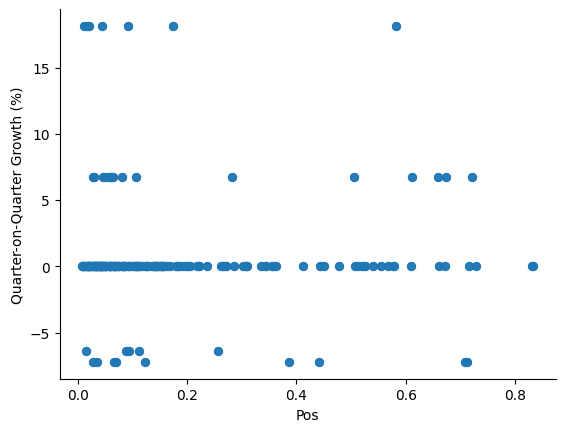

In [31]:
# @title Pos vs Quarter-on-Quarter Growth (%)

from matplotlib import pyplot as plt
train1.plot(kind='scatter', x='Pos', y='Quarter-on-Quarter Growth (%)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [32]:
autof.reset_index(inplace=True)

In [33]:
Ford_price = yf.Ticker('F').history(period='max')
Ford_price.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

Ford_price.reset_index(inplace=True)
Ford_price['Date'] = pd.to_datetime(Ford_price['Date']).dt.strftime('%Y-%m-%d')
Ford_price.head()

,Date,Open,High,Low,Close,Volume
0,1972-06-01,0.000000,0.237764,0.235103,0.235547,1091238
1,1972-06-02,0.235547,0.237765,0.234216,0.235103,1174468
2,1972-06-05,0.235103,0.237321,0.234216,0.235103,5209582
3,1972-06-06,0.235103,0.235990,0.231554,0.232442,1424158
4,1972-06-07,0.232442,0.233772,0.231111,0.231111,675088


In [34]:
GM_price = yf.Ticker('GM').history(period='max')
GM_price.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

GM_price.reset_index(inplace=True)
GM_price['Date'] = pd.to_datetime(GM_price['Date']).dt.strftime('%Y-%m-%d')
GM_price.head()

,Date,Open,High,Low,Close,Volume
0,2010-11-18,26.495665,27.245115,25.655374,25.882479,457044300
1,2010-11-19,25.852195,26.117151,25.064895,25.935465,107842000
2,2010-11-22,25.890045,26.102010,25.594808,25.799204,36650600
3,2010-11-23,25.700793,25.731075,25.125457,25.170879,31170200
4,2010-11-24,25.534239,25.587230,25.148160,25.344984,26138000


In [35]:
Tesla_price = yf.Ticker('TSLA').history(period='max')
Tesla_price.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

Tesla_price.reset_index(inplace=True)
Tesla_price['Date'] = pd.to_datetime(Tesla_price['Date']).dt.strftime('%Y-%m-%d')
Tesla_price.head()

,Date,Open,High,Low,Close,Volume
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,281494500
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,257806500
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,123282000
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,77097000
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,103003500


In [36]:
Ford_price.rename(columns={'Date': 'date'}, inplace=True)
GM_price.rename(columns={'Date': 'date'}, inplace=True)
Tesla_price.rename(columns={'Date': 'date'}, inplace=True)

In [37]:
def label_text(row):
    if row['Close'] > row['Open']:
        return 1
    else:
        return 0

In [38]:
GM_price['Label'] = GM_price.apply(label_text, axis=1)
Tesla_price['Label'] = Tesla_price.apply(label_text, axis=1)
Ford_price['Label'] = Ford_price.apply(label_text, axis=1)

In [39]:
train2 = pd.concat([GM_price, Tesla_price], axis=0)
train2['date'] = pd.to_datetime(train2['date'])

test2 = pd.concat([Ford_price], axis=0)
test2['date'] = pd.to_datetime(test2['date'])

In [40]:
train2.head()

,date,Open,High,Low,Close,Volume,Label
0,2010-11-18,26.495665,27.245115,25.655374,25.882479,457044300,0
1,2010-11-19,25.852195,26.117151,25.064895,25.935465,107842000,1
2,2010-11-22,25.890045,26.102010,25.594808,25.799204,36650600,0
3,2010-11-23,25.700793,25.731075,25.125457,25.170879,31170200,0
4,2010-11-24,25.534239,25.587230,25.148160,25.344984,26138000,0


In [41]:
train = pd.merge(train1, train2, left_on='Date', right_on='date').drop(columns=['date'])
test = pd.merge(test1, test2, left_on='Date', right_on='date').drop(columns=['date'])

In [42]:
train = train[train['Label'] != -1]

In [43]:
train

,Text,Date,Neg,Neu,Pos,Quarter-on-Quarter Growth (%),PE,DE,Open,High,Low,Close,Volume,Label
0,auto industryrelated employment fuel retailer ...,2024-06-12,0.031132,0.907375,0.061493,0.0,57.458862,15.206,48.840000,49.349998,48.630001,48.860001,14222200,1
1,auto industryrelated employment fuel retailer ...,2024-06-12,0.031132,0.907375,0.061493,0.0,57.458862,15.206,171.119995,180.550003,169.800003,177.289993,90389400,1
2,auto industryrelated employment fuel retailer ...,2024-06-12,0.031132,0.907375,0.061493,0.0,57.458862,15.206,48.840000,49.349998,48.630001,48.860001,14222200,1
3,auto industryrelated employment fuel retailer ...,2024-06-12,0.031132,0.907375,0.061493,0.0,57.458862,15.206,171.119995,180.550003,169.800003,177.289993,90389400,1
4,bnplus investment plan byd intends start produ...,2024-06-05,0.012823,0.680314,0.306863,0.0,57.458862,15.206,45.430158,45.569789,44.702079,45.499973,24724900,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683,bike retake precovid peak two year tv,2024-05-10,0.045215,0.853642,0.101142,0.0,NaN,NaN,173.050003,173.059998,167.750000,168.470001,72627200,0
684,vehicle retail sale soar april twowheeler regi...,2024-05-09,0.013805,0.763963,0.222232,0.0,NaN,NaN,44.861657,45.539868,44.682130,45.240658,9349800,1
685,vehicle retail sale soar april twowheeler regi...,2024-05-09,0.013805,0.763963,0.222232,0.0,NaN,NaN,175.009995,175.619995,171.369995,171.970001,65950300,0
686,vehicle retail sale soar april twowheeler regi...,2024-05-09,0.013805,0.763963,0.222232,0.0,NaN,NaN,44.861657,45.539868,44.682130,45.240658,9349800,1


In [44]:
train = train.fillna(0)
test = test.fillna(0)

In [45]:
X_train = train[["Quarter-on-Quarter Growth (%)", "Neg", "Neu", "Pos","PE","DE"]]
y_train = train["Label"]
X_test = test[["Quarter-on-Quarter Growth (%)", "Neg", "Neu", "Pos","PE","DE"]]
y_test = test["Label"]

In [47]:
X_train

,Quarter-on-Quarter Growth (%),Neg,Neu,Pos,PE,DE
0,0.0,0.031132,0.907375,0.061493,57.458862,15.206
1,0.0,0.031132,0.907375,0.061493,57.458862,15.206
2,0.0,0.031132,0.907375,0.061493,57.458862,15.206
3,0.0,0.031132,0.907375,0.061493,57.458862,15.206
4,0.0,0.012823,0.680314,0.306863,57.458862,15.206
...,...,...,...,...,...,...
683,0.0,0.045215,0.853642,0.101142,0.000000,0.000
684,0.0,0.013805,0.763963,0.222232,0.000000,0.000
685,0.0,0.013805,0.763963,0.222232,0.000000,0.000
686,0.0,0.013805,0.763963,0.222232,0.000000,0.000


In [48]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.8 MB/s eta 0:00:00


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [50]:
def getMetrics(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    return accuracy, precision, recall, f1, roc_auc

rf_clf = RandomForestClassifier(max_depth=5,random_state=42)
svm_clf = SVC(random_state=42)
lr_clf = LogisticRegression(random_state=42)
catboost_clf = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=False, random_state=42)
xgboost_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
adaboost_clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

In [51]:
for clf in tqdm([rf_clf, svm_clf, lr_clf, catboost_clf, xgboost_clf, adaboost_clf]):
    accuracy, precision, recall, f1, roc_auc = getMetrics(clf, X_train, y_train, X_test, y_test)
    print(f"{clf.__class__.__name__}:")
    print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, ROC-AUC: {roc_auc:.2f}")

  0%|          | 0/6 [00:00<?, ?it/s]

RandomForestClassifier:
Accuracy: 0.55, Precision: 0.52, Recall: 0.98, F1-Score: 0.68, ROC-AUC: 0.57
SVC:
Accuracy: 0.48, Precision: 0.48, Recall: 0.98, F1-Score: 0.64, ROC-AUC: 0.50
LogisticRegression:
Accuracy: 0.49, Precision: 0.49, Recall: 1.00, F1-Score: 0.65, ROC-AUC: 0.52
CatBoostClassifier:
Accuracy: 0.66, Precision: 0.60, Recall: 0.89, F1-Score: 0.72, ROC-AUC: 0.67
XGBClassifier:
Accuracy: 0.67, Precision: 0.61, Recall: 0.82, F1-Score: 0.70, ROC-AUC: 0.68
AdaBoostClassifier:
Accuracy: 0.52, Precision: 0.50, Recall: 0.99, F1-Score: 0.66, ROC-AUC: 0.54


In [52]:
test

,Text,Date,Neg,Neu,Pos,Quarter-on-Quarter Growth (%),PE,DE,Open,High,Low,Close,Volume,Label
0,auto industryrelated employment fuel retailer ...,2024-06-12,0.031132,0.907375,0.061493,0.0,57.458862,15.206,12.28,12.37,12.03,12.08,57116200,0
1,bnplus investment plan byd intends start produ...,2024-06-05,0.012823,0.680314,0.306863,0.0,57.458862,15.206,12.05,12.12,11.82,12.07,45509800,1
2,japanese meanwhile keen promote hydrogen indus...,2024-06-03,0.010447,0.412688,0.576865,0.0,57.458862,15.206,12.25,12.32,12.02,12.19,53784100,0
3,strong hybrid need replace ice model ev maruti...,2024-06-03,0.109443,0.782082,0.108475,0.0,0.000000,0.000,12.25,12.32,12.02,12.19,53784100,0
4,gift nifty soar point here trading setup today...,2024-06-03,0.010659,0.632373,0.356968,0.0,0.000000,0.000,12.25,12.32,12.02,12.19,53784100,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,thief u robbing catalytic converter car,2024-05-30,0.843040,0.147763,0.009197,0.0,0.000000,0.000,11.58,11.78,11.48,11.77,42249500,1
168,car dealer may end crore worth inventory deman...,2024-05-30,0.066761,0.625231,0.308007,0.0,0.000000,0.000,11.58,11.78,11.48,11.77,42249500,1
169,european share muted loss energy offset gain f...,2024-05-16,0.174181,0.783818,0.042001,0.0,0.000000,0.000,12.27,12.48,12.26,12.38,41502200,1
170,bike retake precovid peak two year tv,2024-05-10,0.045215,0.853642,0.101142,0.0,0.000000,0.000,12.15,12.17,11.91,11.99,51447800,0


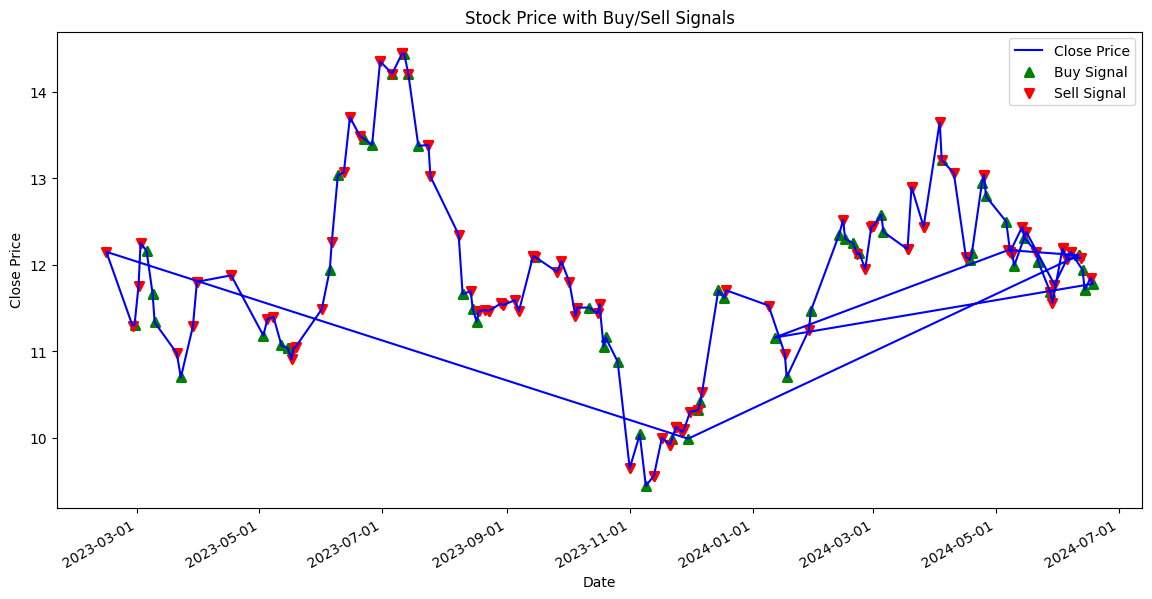

In [59]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

y_pred = xgboost_clf.predict(X_test)
test['Date'] = pd.to_datetime(test['Date'])
plt.figure(figsize=(14, 7))
plt.plot(test['Date'], test['Close'], label='Close Price', color='blue')
plt.scatter(test.loc[y_test.index, 'Date'][y_pred == 0], test.loc[y_test.index, 'Close'][y_pred == 0],label='Buy Signal', color='green', marker='^', linewidths=2 )
plt.scatter(test.loc[y_test.index, 'Date'][y_pred == 1], test.loc[y_test.index, 'Close'][y_pred == 1], label='Sell Signal', color='red', marker='v', linewidths=2)
plt.title('Stock Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
locator = mdates.AutoDateLocator(minticks=10, maxticks=15)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.show()

In [58]:
initial_cash = 10000
cash = initial_cash
shares = 0
portfolio_values = []
trade_dates = []
entry_prices = []
exit_prices = []
num_trades = 0
close_index = test.columns.get_loc('Close')

for i in range(len(test) - 1):
    if y_pred[i] == 0:
        if cash > 0:
            shares = cash / test.iloc[i+1, close_index]
            cash = 0
            trade_dates.append(test.iloc[i+1, test.columns.get_loc('Date')])
            entry_prices.append(test.iloc[i+1, close_index])
            num_trades += 1
    elif y_pred[i] == 1:
        if shares > 0:
            cash = shares * test.iloc[i+1, close_index]
            shares = 0
            trade_dates.append(test.iloc[i+1, test.columns.get_loc('Date')])
            exit_prices.append(test.iloc[i+1, close_index])
            num_trades += 1

    portfolio_value = cash + shares * test.iloc[i+1, close_index]
    portfolio_values.append(portfolio_value)

if shares > 0:
    portfolio_value = cash + shares * test.iloc[len(test) - 1, close_index]
    portfolio_values.append(portfolio_value)
else:
    portfolio_values.append(cash)

final_portfolio_value = portfolio_values[-1]
returns = (final_portfolio_value - initial_cash) / initial_cash * 100

daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]

risk_free_rate = 0.047
sharpe_ratio = (np.mean(daily_returns) - risk_free_rate / 252) / np.std(daily_returns) * np.sqrt(252)

cumulative_returns = np.array(portfolio_values) / initial_cash
drawdowns = 1 - cumulative_returns / np.maximum.accumulate(cumulative_returns)
max_drawdown = np.max(drawdowns)

win_trades = sum([exit > entry for entry, exit in zip(entry_prices, exit_prices)])
win_ratio = win_trades / num_trades if num_trades > 0 else 0

print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
print(f"Total Returns: {returns:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2f}")
print(f"Number of Trades Executed: {num_trades}")
print(f"Win Ratio: {win_ratio:.2f}")

Final Portfolio Value: $12886.64
Total Returns: 28.87%
Sharpe Ratio: 1.16
Maximum Drawdown: 0.19
Number of Trades Executed: 71
Win Ratio: 0.25
